In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
data = pd.read_excel("owid-covid-data.xlsx")
data.head()

KeyboardInterrupt: 

In [ ]:
#code that filters out European countries
european_countries = [
    'Albania', 'Andorra', 'Armenia', 'Austria', 'Azerbaijan', 'Belarus', 'Belgium',
    'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark',
    'Estonia', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'Iceland',
    'Ireland', 'Italy', 'Kazakhstan', 'Kosovo', 'Latvia', 'Liechtenstein', 'Lithuania',
    'Luxembourg', 'Malta', 'Moldova', 'Monaco', 'Montenegro', 'Netherlands', 'North Macedonia',
    'Norway', 'Poland', 'Portugal', 'Romania', 'Russia', 'San Marino', 'Serbia', 'Slovakia',
    'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'Ukraine', 'United Kingdom', 'Vatican City'
]

# subset for European countries
europe_data = data[data['location'].isin(european_countries)]
europe_data.head()


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
2714,ALB,Europe,Albania,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,51.2,NaN,2.89,78.57,0.795,2842318,NaN,NaN,NaN,NaN
2715,ALB,Europe,Albania,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,51.2,NaN,2.89,78.57,0.795,2842318,NaN,NaN,NaN,NaN
2716,ALB,Europe,Albania,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,51.2,NaN,2.89,78.57,0.795,2842318,NaN,NaN,NaN,NaN
2717,ALB,Europe,Albania,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,51.2,NaN,2.89,78.57,0.795,2842318,NaN,NaN,NaN,NaN
2718,ALB,Europe,Albania,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,51.2,NaN,2.89,78.57,0.795,2842318,NaN,NaN,NaN,NaN


In [ ]:
# create a table that shows the number of features with more than 30% missing values for each country
def missing_features_by_country(df):

    missingness = df.groupby('location').apply(lambda group: group.isna().mean() * 100)
    
    # Count the number of features with more than 30% missing values for each country
    features_missing_40 = (missingness > 40).sum(axis=1)
    
    # Create a summary DataFrame
    summary = pd.DataFrame({
        'Country': features_missing_40.index,
        'Features with >40% Missingness': features_missing_40.values
    })
    
    return summary.sort_values(by='Features with >40% Missingness', ascending=True)

# Calculate and display the results
missing_features_summary = missing_features_by_country(europe_data)
print(missing_features_summary)

                   Country  Features with >40% Missingness
21                   Italy                               7
6                  Belgium                               9
12                 Estonia                              11
43                   Spain                              14
26               Lithuania                              14
14                  France                              15
11                 Denmark                              16
20                 Ireland                              16
27              Luxembourg                              18
45             Switzerland                              19
17                  Greece                              19
35                  Poland                              21
36                Portugal                              22
16                 Germany                              22
41                Slovakia                              22
13                 Finland                              

In [ ]:
# check for overall missingness
missing_values_by_location = europe_data.groupby('location').apply(lambda x: x.isnull().sum())
missing_values_df = pd.DataFrame(missing_values_by_location)
columns_to_exclude = ["iso_code", "continent", "location", "date"]
missing_values_df['sum_missing'] = missing_values_df.drop(columns=columns_to_exclude).sum(axis=1)
missing_total_by_location = missing_values_df[['location', 'sum_missing']]
missing_total_by_location = missing_total_by_location.sort_values(by='sum_missing', ascending=True)
missing_total_by_location.head(20)

,location,sum_missing
location,,
Italy,0,18094
Belgium,0,20668
France,0,21166
Estonia,0,23902
Switzerland,0,25625
Spain,0,25661
Lithuania,0,26176
Luxembourg,0,26640
Ireland,0,27108


In [7]:
# pick countries that have relatively low missingness and that are adjacent 
netherlands = ['Netherlands']
selected_data = europe_data[europe_data['location'].isin(netherlands)]
selected_data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
209607,NLD,Europe,Netherlands,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,27.3,NaN,3.32,82.28,0.944,17564020,NaN,NaN,NaN,NaN
209608,NLD,Europe,Netherlands,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,27.3,NaN,3.32,82.28,0.944,17564020,NaN,NaN,NaN,NaN
209609,NLD,Europe,Netherlands,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,27.3,NaN,3.32,82.28,0.944,17564020,-259.2,-7.71,-7.71,-14.867022
209610,NLD,Europe,Netherlands,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,27.3,NaN,3.32,82.28,0.944,17564020,NaN,NaN,NaN,NaN
209611,NLD,Europe,Netherlands,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,27.3,NaN,3.32,82.28,0.944,17564020,NaN,NaN,NaN,NaN


In [8]:
# number of available data from different days
date_count_by_location = selected_data.groupby('location')['date'].nunique()
date_count_by_location_sorted = date_count_by_location.sort_values(ascending=True)
date_count_by_location_sorted

location
Netherlands    1357
Name: date, dtype: int64

In [10]:
# check for missingness by country
missing_values_by_location = selected_data.groupby('location').apply(lambda x: x.isnull().sum())
missing_values_df = pd.DataFrame(missing_values_by_location)
missing_values_df.to_csv('missing_values.csv')

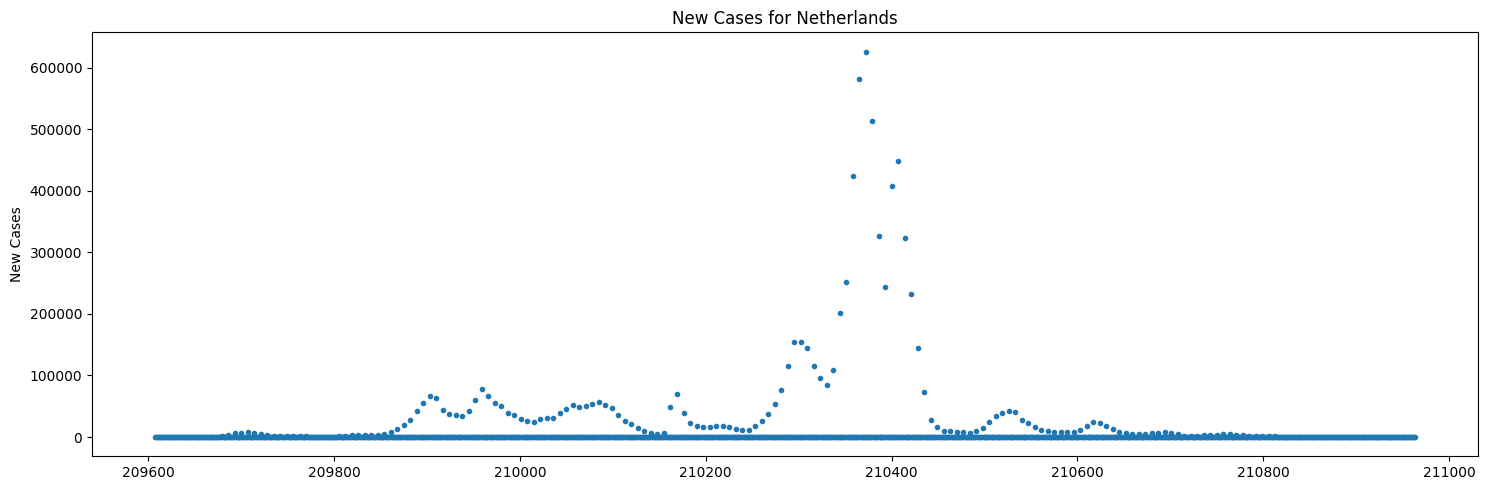

In [11]:
#selected_data['date'] = pd.to_datetime(selected_data['date'])
#selected_data.set_index('date', inplace=True)
#selected_data.sort_index(inplace=True)
locations = selected_data['location'].unique()

plt.figure(figsize=(15, 5 * len(locations)))

for i, location in enumerate(locations, 1):
    plt.subplot(len(locations), 1, i)
    selected_data[selected_data['location'] == location]['new_cases'].plot(style='.', title=f'New Cases for {location}')
    plt.ylabel('New Cases')

plt.tight_layout()
plt.show()

We observed zeros in many different countries; this can be attributed to the fact that some countries report weekly instead of daily. Therefore we decided to use new_cases_smoothed as are target variable. 

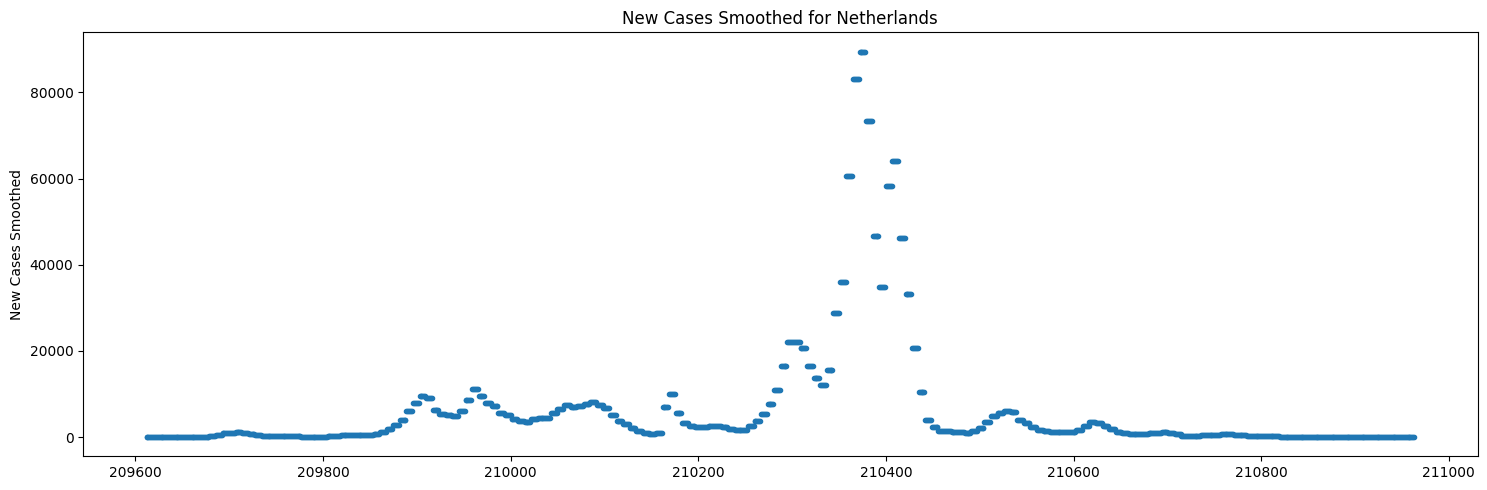

In [12]:
plt.figure(figsize=(15, 5 * len(locations)))

for i, location in enumerate(locations, 1):
    plt.subplot(len(locations), 1, i)
    selected_data[selected_data['location'] == location]['new_cases_smoothed'].plot(style='.', title=f'New Cases Smoothed for {location}')
    plt.ylabel('New Cases Smoothed')

plt.tight_layout()
plt.show()

## Data Cleaning

In [13]:
#data missingness
missing_data = selected_data.isnull().sum()
threshold = 0.4 * len(selected_data)
missing_data = missing_data[missing_data < threshold]
missing_data

iso_code                                        0
continent                                       0
location                                        0
date                                            0
total_cases                                    58
new_cases                                       0
new_cases_smoothed                              5
total_deaths                                   65
new_deaths                                      0
new_deaths_smoothed                             5
total_cases_per_million                        58
new_cases_per_million                           0
new_cases_smoothed_per_million                  5
total_deaths_per_million                       65
new_deaths_per_million                          0
new_deaths_smoothed_per_million                 5
reproduction_rate                             324
icu_patients                                  524
icu_patients_per_million                      524
hosp_patients                                 524


In [14]:
# drop features with >40% missingness
threshold = 0.6 * len(selected_data)

data_clean = selected_data.dropna(thresh=threshold, axis=1)
data_clean.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_vaccinations_smoothed',
       'new_vaccinations_smoothed_per_million',
       'new_people_vaccinated_smoothed',
       'new_people_vaccinated_smoothed_per_hundred', 'stringency_index',
       'population_density', 'median_age', 'aged_65_older', 'aged_70_older',
       'gdp_per_capita', 'cardiovasc_death_rate', 'diabetes_prevalence',
       'female_smokers', 'mal

In [29]:
import pandas as pd



# Create a DataFrame with time series data
df = pd.DataFrame(data)

# Convert 'date' column to datetime type
df['date'] = pd.to_datetime(df['date'])

# Set 'date' column as the DataFrame index (assuming it's not already set)
df.set_index('date', inplace=True)

# Specify the variables you want to fill forward
variables_to_fill_forward = ['variable1', 'variable2']

# Fill forward missing values in the specified variables
df[variables_to_fill_forward] = df[variables_to_fill_forward].fillna(method='ffill')

# Output the DataFrame with filled forward values
print("DataFrame with Forward Filled Values:")
print(df)


DataFrame with Forward Filled Values:
            variable1  variable2  variable3
date                                       
2023-01-01        1.0        NaN        1.0
2023-01-02        1.0        2.0        2.0
2023-01-03        3.0        2.0        NaN
2023-01-04        3.0        4.0        NaN
2023-01-05        5.0        4.0        5.0


/var/folders/b5/qm3sgd6j10z7nryx5bnfdwb40000gn/T/ipykernel_4576/3603969706.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[variables_to_fill_forward] = df[variables_to_fill_forward].fillna(method='ffill')


In [31]:
import pandas as pd

# Sample DataFrame with missing values
data = {
    'col1': [1, None, 3, None, 5],
    'col2': [1, 2, None, 4, 5],
    'col3': [1, 2, 3, 4, 5]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Filter variables with missing values
variables_with_missing_values = df.columns[df.isnull().any()].tolist()

# Output the variables with missing values
print("Variables with Missing Values:", variables_with_missing_values)


Variables with Missing Values: ['col1', 'col2']


In [34]:
data_vif = data_clean_imputed.copy()
columns_to_drop = ['population', 'diabetes_prevalence', 'aged_65_older',
                   'life_expectancy','total_cases', 'total_deaths_per_million',
                   'new_people_vaccinated_smoothed', 'median_age', 'human_development_index',
                   'male_smokers', 'cardiovasc_death_rate', 'hosp_patients_per_million',
                    'hospital_beds_per_thousand', 'aged_70_older', 'weekly_hosp_admissions_per_million',
                    'icu_patients_per_million','new_deaths_smoothed_per_million', 'new_vaccinations_smoothed_per_million',
                    'female_smokers', 'total_cases_per_million', 'hosp_patients', 'new_deaths_per_million', 'new_people_vaccinated_smoothed_per_hundred',
                    'total_deaths', 'new_cases_smoothed_per_million', 'new_cases_per_million', 'new_deaths', 'new_cases'] 
data_vif_cleaned = data_vif.drop(columns=columns_to_drop)

data_numeric = data_vif_cleaned.select_dtypes(include=[np.number])
vif_data = pd.DataFrame()
vif_data["Variable"] = data_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(data_numeric.values, i) for i in range(data_numeric.shape[1])]

vif_data = vif_data.sort_values(by="VIF", ascending=False)
print(vif_data)


NameError: name 'data_clean_imputed' is not defined

In [19]:
data_clean_imputed = data_clean_imputed.drop(columns=columns_to_drop)
data_clean_imputed.shape

(13570, 14)

In [20]:
data_clean_imputed.head()

,iso_code,continent,location,date,new_cases_smoothed,new_deaths_smoothed,reproduction_rate,icu_patients,weekly_hosp_admissions,new_vaccinations_smoothed,stringency_index,population_density,gdp_per_capita,extreme_poverty
28497,BEL,Europe,Belgium,2020-01-03,45.3714,-1.421085e-14,0.988,4.0,116.2,84.6,0.0,375.564,42658.576,0.2
28498,BEL,Europe,Belgium,2020-01-04,45.3714,-1.421085e-14,0.988,4.0,116.2,84.6,0.0,375.564,42658.576,0.2
28499,BEL,Europe,Belgium,2020-01-05,45.3714,-1.421085e-14,0.988,4.0,116.2,84.6,0.0,375.564,42658.576,0.2
28500,BEL,Europe,Belgium,2020-01-06,45.3714,-1.421085e-14,0.988,4.0,116.2,84.6,0.0,375.564,42658.576,0.2
28501,BEL,Europe,Belgium,2020-01-07,45.3714,-1.421085e-14,0.988,4.0,116.2,84.6,0.0,375.564,42658.576,0.2


## Time Series Decomposition

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


for country in data_clean_imputed['location'].unique():
    country_data = data_clean_imputed[data_clean_imputed['location'] == country]
    result = seasonal_decompose(country_data['new_cases_smoothed'], period=365)
    
    plt.figure(figsize=(10, 6))
    
    # Create plots
    result.plot()
    
    # Set the title with a higher y value to shift it up
    plt.suptitle(f'Seasonal Decomposition - {country}', y=1.05)
    
    # Save the figure with a lowercase country name
    plt.savefig('acf_plot_' + country.lower() + '.png')
    
    # Display the figure
    plt.show()



NameError: name 'data_clean_imputed' is not defined

In [22]:
pip install statsmodels

4235.61s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 755.6 kB/s eta 0:00:0000:0100:01
  Obtaining dependency information for scipy!=1.9.2,>=1.4 from https://files.pythonhosted.org/packages/b1/a6/b6d66d4f4045ba59200d25f254ccd63340162c903f95231e3ae6863fc4ae/scipy-1.11.3-cp311-cp311-macosx_10_9_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 270.5 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 kB 1.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.2/37.2 MB 638.8 kB/s eta 0:00:0000:0100:02

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [22]:
plt.savefig('autocorrelation_plot.png')

<Figure size 640x480 with 0 Axes>

## Time Series Data Stationary

In [ ]:
from statsmodels.tsa.stattools import adfuller

for country in data_clean_imputed['location'].unique():
    country_data = data_clean_imputed[data_clean_imputed['location'] == country]
    result = adfuller(country_data['new_cases_smoothed'].values)
    
    print(f'Results for {country}:')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print('---------------------------------------------')


Results for Belgium:
ADF Statistic: -3.185635
p-value: 0.020831
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
---------------------------------------------
Results for Ireland:
ADF Statistic: -3.228222
p-value: 0.018408
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
---------------------------------------------
Results for Italy:
ADF Statistic: -3.244839
p-value: 0.017532
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
---------------------------------------------
Results for Luxembourg:
ADF Statistic: -3.176654
p-value: 0.021376
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
---------------------------------------------
Results for France:
ADF Statistic: -3.929443
p-value: 0.001829
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
---------------------------------------------
Results for Netherlands:
ADF Statistic: -2.848083
p-value: 0.051727
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
---------------------------------------------
Results for 

## Feature Creation

### Auto Correlation

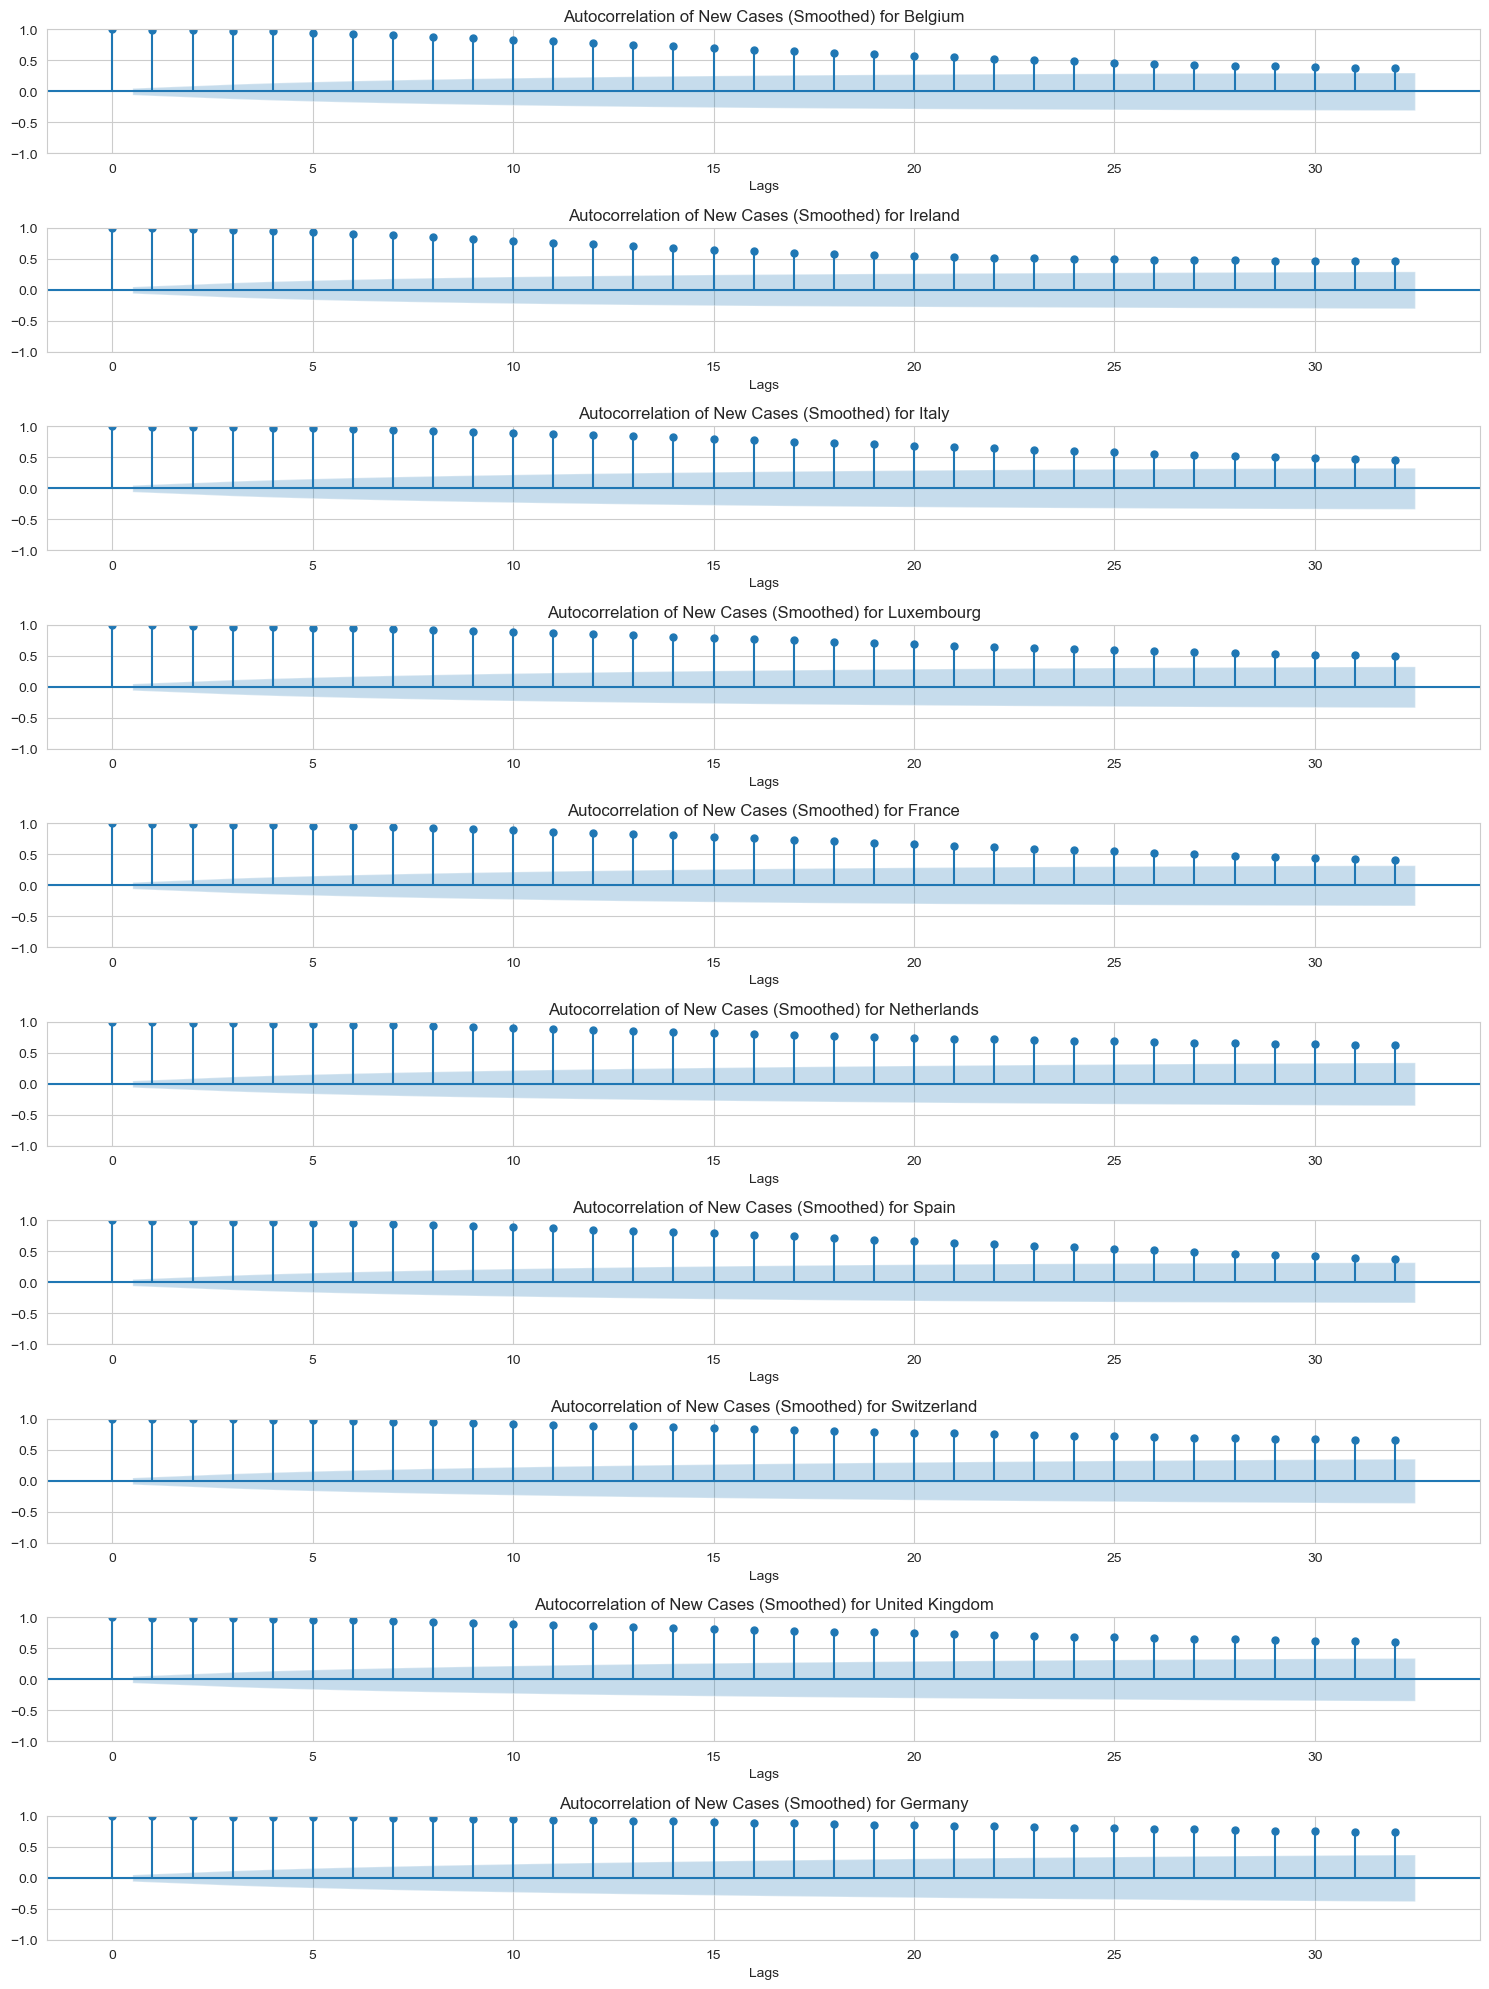

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

countries = data_clean_imputed['location'].unique()

plt.figure(figsize=(15, 20))

for i, country in enumerate(countries, 1):
    plt.subplot(len(countries), 1, i)
    country_data = data_clean_imputed[data_clean_imputed['location'] == country]['new_cases_smoothed']
    plot_acf(country_data.dropna(), alpha=0.05, ax=plt.gca())
    plt.title(f'Autocorrelation of New Cases (Smoothed) for {country}')
    plt.xlabel('Lags')

plt.tight_layout()
plt.show()

### Rolling and Lag Features

In [ ]:
# lagged features with new_cases
for lag in [1, 7, 14]:
    data_clean_imputed[f'new_cases_lag{lag}'] = data_clean_imputed['new_cases_smoothed'].shift(lag)

In [ ]:
# rolling window 7-day and 14-day for new_cases
for window in [7, 14]:
    data_clean_imputed[f'new_cases_roll_mean{window}'] = data_clean_imputed['new_cases_smoothed'].rolling(window=window).mean()
    data_clean_imputed[f'new_cases_roll_std{window}'] = data_clean_imputed['new_cases_smoothed'].rolling(window=window).std()

In [ ]:
data_clean_imputed.head(10)

,iso_code,continent,location,new_cases_smoothed,new_deaths_smoothed,reproduction_rate,icu_patients,weekly_hosp_admissions,new_vaccinations_smoothed,stringency_index,population_density,gdp_per_capita,extreme_poverty,new_cases_lag1,new_cases_lag7,new_cases_lag14,new_cases_roll_mean7,new_cases_roll_std7,new_cases_roll_mean14,new_cases_roll_std14
date,,,,,,,,,,,,,,,,,,,,
2020-01-03,BEL,Europe,Belgium,0.0000,-1.421085e-14,0.988,7.8,116.2,84.6,0.0,375.564,42658.576,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,IRL,Europe,Ireland,0.0000,-1.421085e-14,0.828,5.0,242.6,24.0,0.0,69.874,67335.293,0.2,0.0000,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,ITA,Europe,Italy,0.0000,-1.421085e-14,1.118,25.8,268.2,44.2,0.0,205.859,35220.084,2.0,0.0000,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,LUX,Europe,Luxembourg,3.0858,-1.421085e-14,1.110,0.8,8.0,48.6,0.0,231.447,94277.965,0.2,0.0000,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,FRA,Europe,France,11870.8288,1.982840e+01,0.978,868.4,3311.6,2027.4,0.0,122.578,38605.671,1.0,3.0858,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,NLD,Europe,Netherlands,6.5144,-1.421085e-14,1.564,4.4,112.4,42.6,0.0,508.544,48472.545,0.2,11870.8288,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,ESP,Europe,Spain,783.5144,1.322840e+01,1.188,114.8,1440.6,3418.0,0.0,93.105,34272.360,1.0,6.5144,NaN,NaN,1809.134771,4446.341995,NaN,NaN
2020-01-03,CHE,Europe,Switzerland,166.6854,8.570000e-01,0.634,15.6,239.8,191.8,0.0,214.243,57410.166,0.2,783.5144,0.0,NaN,1832.946971,4435.471508,NaN,NaN
2020-01-03,GBR,Europe,United Kingdom,0.0000,-1.421085e-14,0.820,187.8,4201.4,12670.6,0.0,272.898,39753.244,0.2,166.6854,0.0,NaN,1832.946971,4435.471508,NaN,NaN


### Additional Features 

In [ ]:
# Data time features
data_clean_imputed['day_of_week'] = data_clean_imputed.index.dayofweek
# 0 refers to Monday and 6 to Sunday, we want to tell if the date is weekend or not
data_clean_imputed['weekend'] = np.where(data_clean_imputed['day_of_week'].isin([5, 6]), 1, 0)
data_clean_imputed['month'] = data_clean_imputed.index.month
data_clean_imputed['year'] = data_clean_imputed.index.year
data_clean_imputed.head(2)

,iso_code,continent,location,new_cases_smoothed,new_deaths_smoothed,reproduction_rate,icu_patients,weekly_hosp_admissions,new_vaccinations_smoothed,stringency_index,...,new_cases_lag7,new_cases_lag14,new_cases_roll_mean7,new_cases_roll_std7,new_cases_roll_mean14,new_cases_roll_std14,day_of_week,weekend,month,year
date,,,,,,,,,,,,,,,,,,,,,
2020-01-03,BEL,Europe,Belgium,0.0,-1.421085e-14,0.988,7.8,116.2,84.6,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4,0,1,2020
2020-01-03,IRL,Europe,Ireland,0.0,-1.421085e-14,0.828,5.0,242.6,24.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4,0,1,2020


In [ ]:
data_clean_imputed['date'] = data_clean_imputed.index
data_clean_imputed['season'] = data_clean_imputed['date'].apply( lambda x: 'Winter' if x.month == 12 or x.month == 1 or 
                                      x.month == 2 else 'Spring' if  x.month == 3 or 
                                      x.month == 4 or x.month == 5 else 'Summer' if  
                                      x.month == 6 or x.month == 7 or 
                                      x.month == 8 else 'Autumn' if  
                                      x.month == 9 or x.month == 10 or x.month == 11 else '')

In [ ]:
pip install holidays


[notice] A new release of pip is available: 23.1.2 -> 23.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import holidays
import datetime
data_clean_imputed['holidays'] = data_clean_imputed['date'].apply( lambda x: 'Holiday' if x in holidays.US() 
                                      else 'Holiday' if x + datetime.timedelta(days=1) in holidays.US() else 'Normal day' )

In [ ]:
adjacent_countries = {
    'Spain': ['France'],
    'France': ['Spain', 'Belgium', 'Germany', 'Italy', 'Switzerland', 'Luxembourg'],
    'Germany': ['France', 'Belgium', 'Netherlands', 'Switzerland', 'Luxembourg'],
    'Ireland': ['United Kingdom'],
    'United Kingdom': ['Ireland'],
    'Italy': ['France', 'Switzerland'],
    'Belgium': ['France', 'Germany', 'Netherlands', 'Luxembourg'],
    'Netherlands': ['Germany', 'Belgium'],
    'Switzerland': ['France', 'Germany', 'Italy'],
    'Luxembourg': ['France', 'Germany', 'Belgium']
}

data_clean_imputed['adjacent_new_cases'] = 0

for country in adjacent_countries:
    if country in data_clean_imputed['location'].unique():
        adjacent_data = data_clean_imputed[data_clean_imputed['location'].isin(adjacent_countries[country])]
        daily_sum = adjacent_data.groupby('date')['new_cases'].sum()
        country_data = data_clean_imputed[data_clean_imputed['location'] == country]
        country_data = pd.merge(country_data, daily_sum, how='left', left_index=True, right_index=True, suffixes=('', '_adjacent'))
        if country in adjacent_countries[country]:
            country_data['new_cases_adjacent'] -= country_data['new_cases']
        
data_clean_imputed.loc[data_clean_imputed['location'] == country, 'adjacent_new_cases'] = country_data['new_cases_adjacent'].fillna(0)

data_clean_imputed[['location', 'new_cases', 'adjacent_new_cases']]


ValueError: 'date' is both an index level and a column label, which is ambiguous.

## Test Train Split

In [ ]:
# test train split
train_size = 0.8  
split_idx = int(len(data_clean_imputed) * train_size)
train = data_clean_imputed.iloc[:split_idx]
test = data_clean_imputed.iloc[split_idx:]

print('Train set shape:', train.shape)
print('Test set shape:', test.shape)


Train set shape: (10856, 27)
Test set shape: (2714, 27)


## EDA

### Univariate Analysis

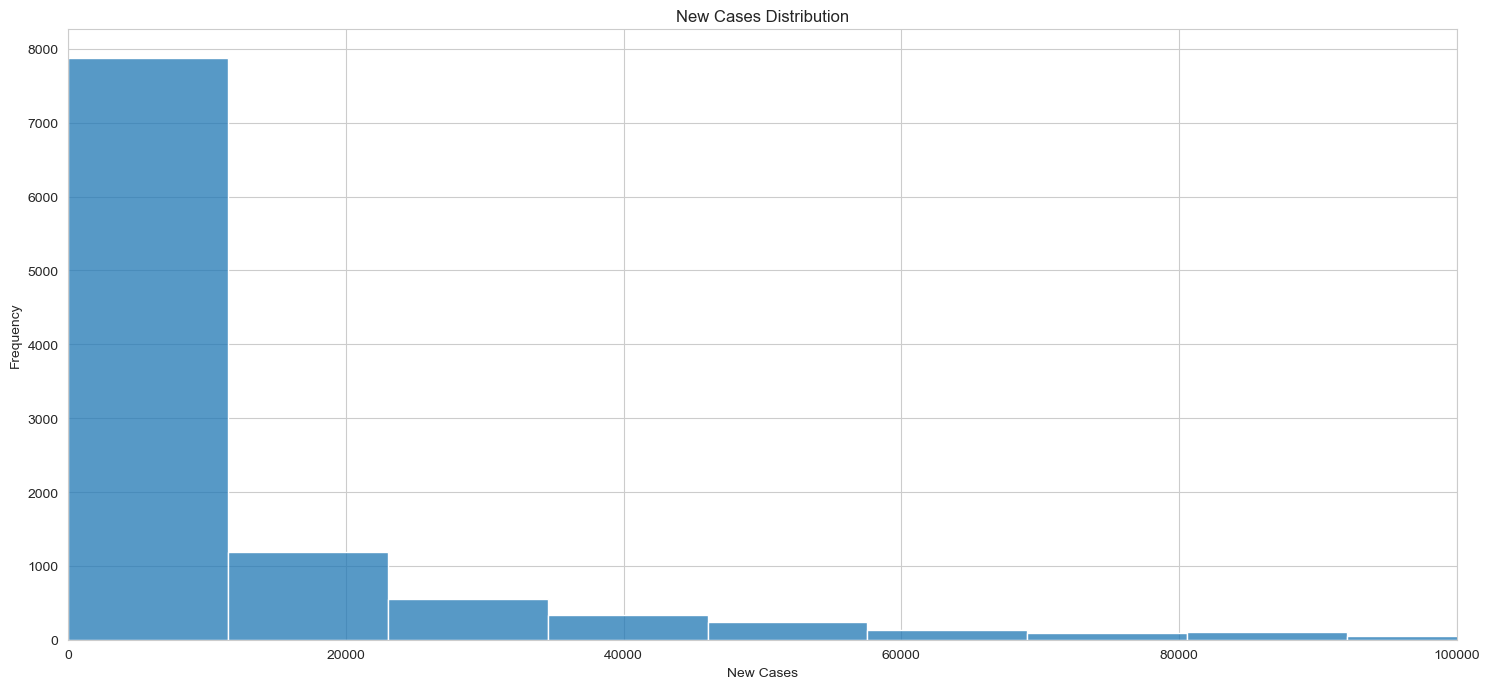

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(15, 7))

sns.histplot(train['new_cases_smoothed'], kde=False, bins=30)
plt.title('New Cases Distribution')
plt.xlabel('New Cases')
plt.ylabel('Frequency')
plt.xlim(0, 100000)

plt.tight_layout()
plt.show()


### Bivariate Analysis

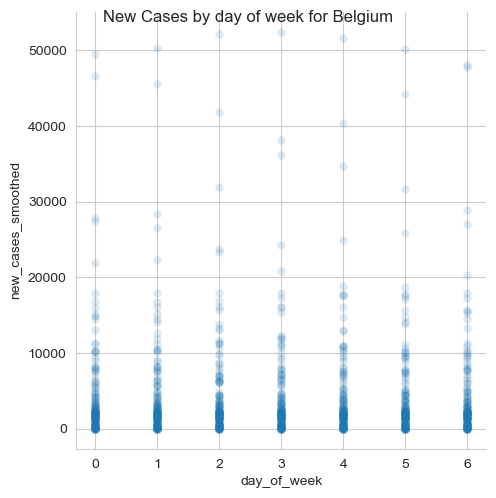

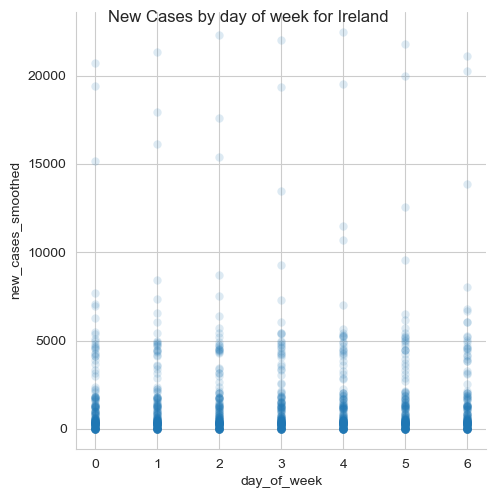

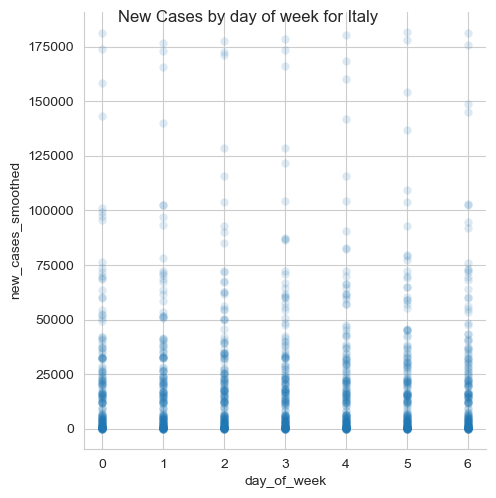

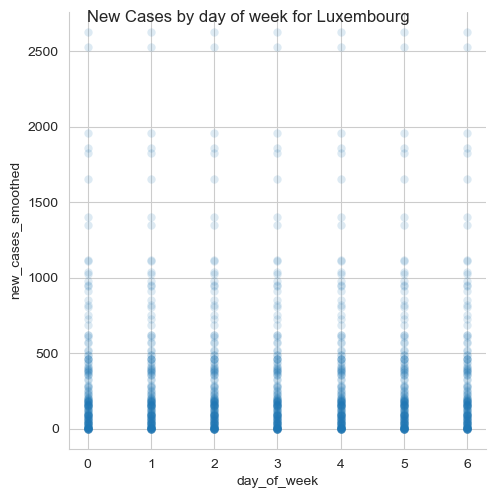

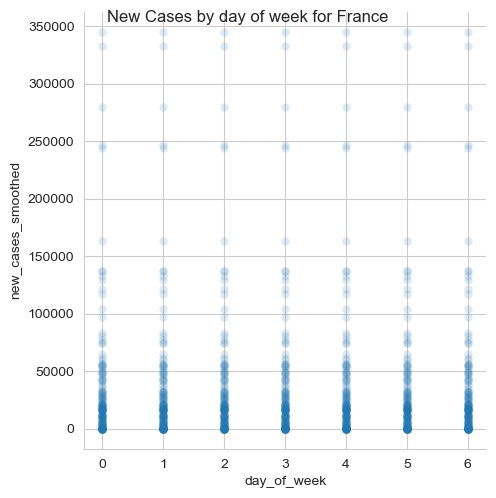

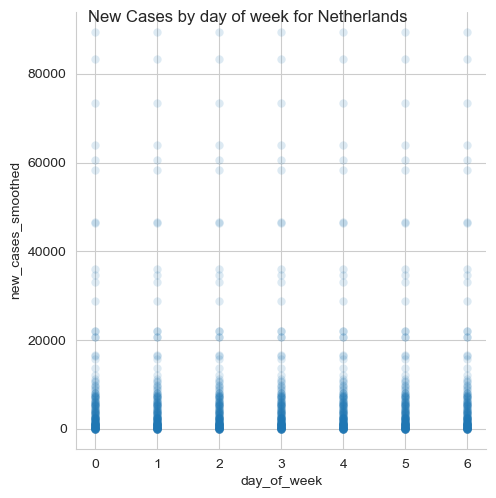

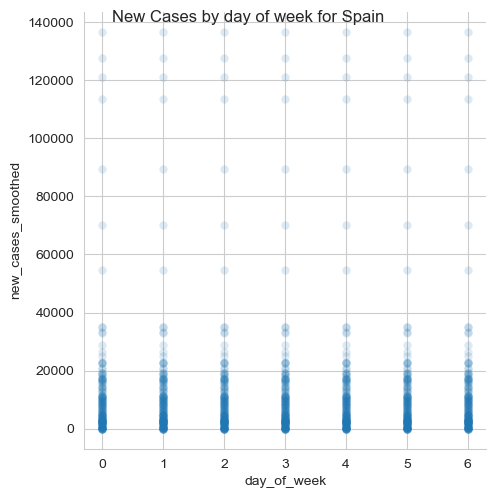

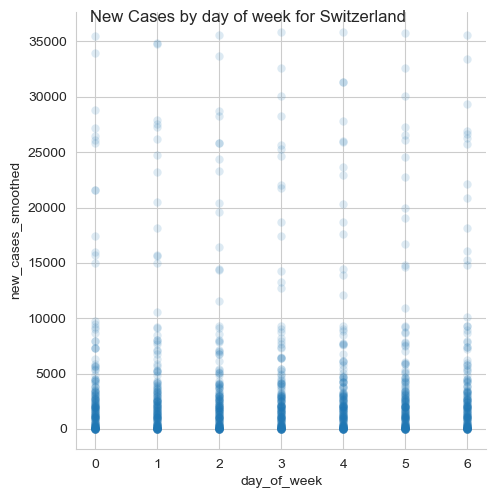

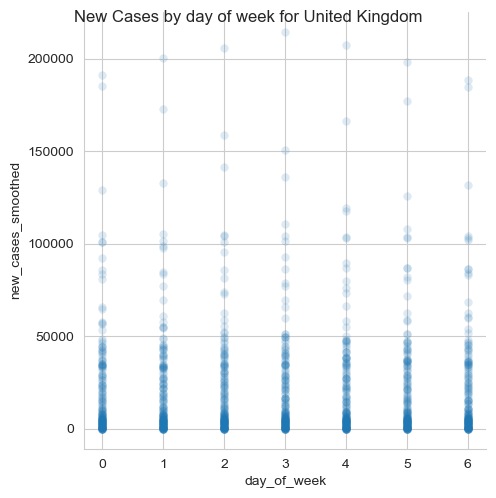

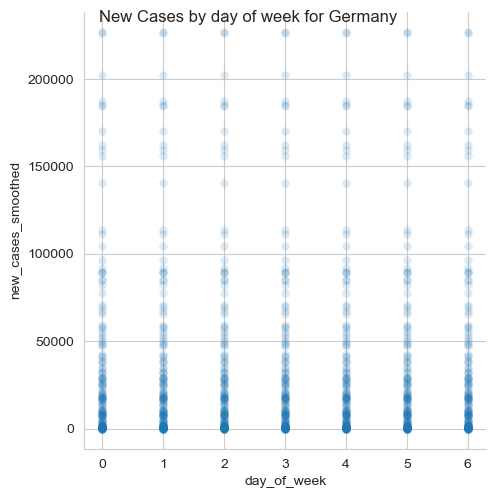

In [ ]:
for country in countries:
    country_data = train[train['location'] == country]

    sns.pairplot(country_data,
                 x_vars=['day_of_week'],
                 y_vars='new_cases_smoothed',
                 height=5,
                 plot_kws={'alpha': 0.15, 'linewidth': 0})
    
    plt.suptitle(f'New Cases by day of week for {country}')
    plt.show()


### Multivariate Analysis

/var/folders/n4/3g40sf9n163fj3t1fbrvlns40000gn/T/ipykernel_3314/2861495228.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = train.corr( method='pearson' )


<Axes: >

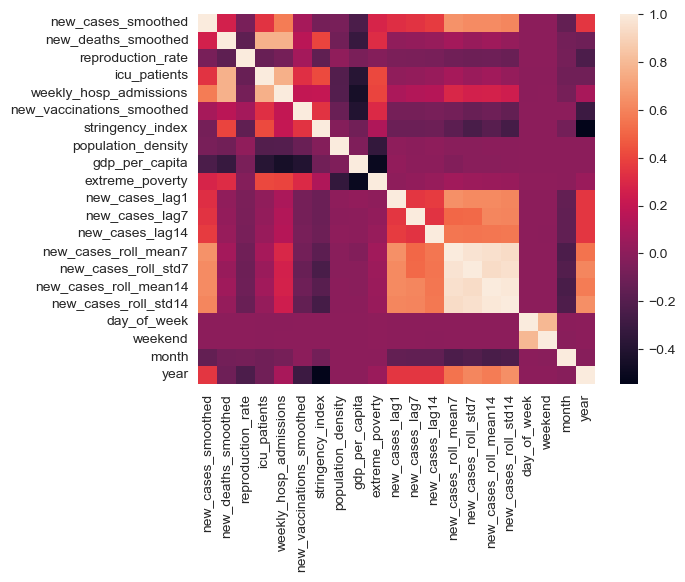

In [ ]:
correlation = train.corr( method='pearson' )
sns.heatmap( correlation )